# Extracting Slums from Satellite Imagery
> * 🔬 Data Science
* 🥠 Deep Learning and pixel-based classification

## Table of Contents
* [Introduction](#Introduction)
* [Export Training Data](#Export-Training-Data)
 * [Preprocessing Slum Boundaries](#Preprocessing-Slum-Boundaries)
 * [Export training data](#Export-training-data)
* [Train the Model](#Train-the-Model)
 * [Prepare Data](#Prepare-Data)
 * [Load an UnetClassifier model](#Load-an-UnetClassifier-model)
 * [Find an Optimal Learning Rate](#Find-an-Optimal-Learning-Rate)
 * [Fit the model](#Fit-the-model)
 * [Save the model](#Save-the-model)
 * [Load an Intermediate model to train it further](#Load-an-Intermediate-model-to-train-it-further)
 * [Preview Results](#Preview-Results)
* [Deploy Model and Extract Slum Boundaries](#Deploy-Model-and-Extract-Slum-Boundaries)
* [Postprocessing](#Postprocessing)
* [Conclusion](#Conclusion)


## Introduction

Every geographical area has its own definition for slum, but slum is usually an area with substandard housing and inadequate services. Slum is an important issue in developing countries as people reside in hazardous living conditions in congested slums and it makes them vulnerable to natural, physical and social disasters. Owing to the sensitivity of the slums, authorities need to continuously track and monitor the growth of the slums.

This sample shows how we can extract the slum boundaries from satellite imagery using the learn module in ArcGIS API for Python.
The model trained here can be deployed on ArcGIS Pro as well as ArcGIS Enterprise and even support distributed processing for quick results.

In this workflow we will basically have three steps.
* Export Training Data using ArcGIS Pro
* Train a Model using learn module in ArcGIS API for Python
* Deploying the Model on ArcGIS Pro

>For this sample we will be using data from Dharavi area in Mumbai, India. For a comparative analysis we will be using imagery for 2004 and 2014 acquired using quickbird and worldview3 sensors with a spatial resolution of 60cm. 

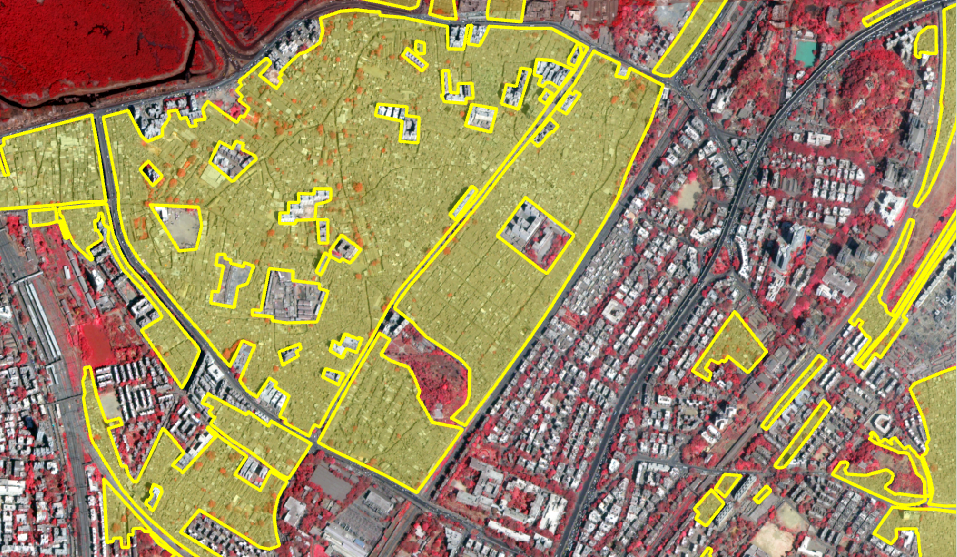

<center>A subset of Imagery overlaid with Training Data (Slum Footprint Layer).</center>

## Export Training Data

We will export training data using the 'Export Training Data For Deep Learning' tool available in [ArcGIS Pro](#"https://pro.arcgis.com/en/pro-app/tool-reference/image-analyst/export-training-data-for-deep-learning.htm") as well as [ArcGIS Enterprise](#"https://developers.arcgis.com/rest/services-reference/export-training-data-for-deep-learning.htm"). For this example we prepared training data in 'Classified Tiles' format using a 'chip_size' of 400px and 'cell_size' of 80cm in ArcGIS Pro. 



### Preprocessing Slum Boundaries

#### Rasterize Slum Boundaries

Rasterize slum boundaries using <a href="https://pro.arcgis.com/en/pro-app/tool-reference/conversion/polygon-to-raster.htm">'Polygon to Raster'</a> tool.

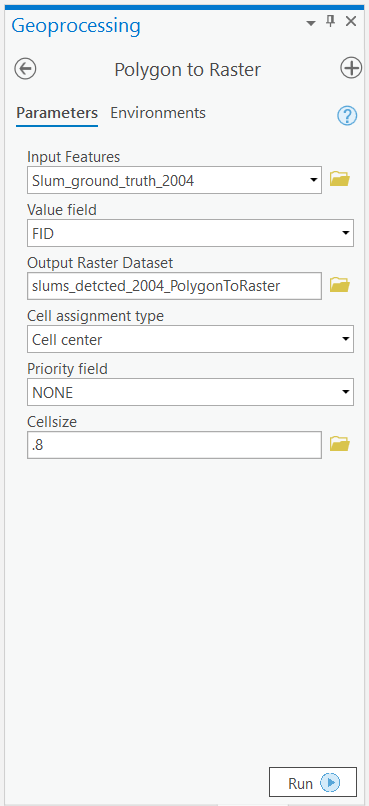</img>

<center>Rasterize slum boundaries</center>


```python
arcpy.conversion.PolygonToRaster("Slum_ground_truth_2004", "FID", r"C:\sample\sample.gdb\Slum_ground_truth_2004_PolygonToRaster", "CELL_CENTER", "NONE", 0.3)
```

#### Reclassify the Rasterized Slum Boundaries

Convert all '**NoData**' values to '**0**' and '**other values**' to '**1**' using ['Reclassify Raster'](https://pro.arcgis.com/en/pro-app/tool-reference/3d-analyst/an-overview-of-the-raster-reclass-toolset.htm) tool.
 After selecting input raster click on 'classify' and set only one class. For the class with 'valid data range' Set 'New' value to '1' for 'NoData' set 'New' value to '0'.

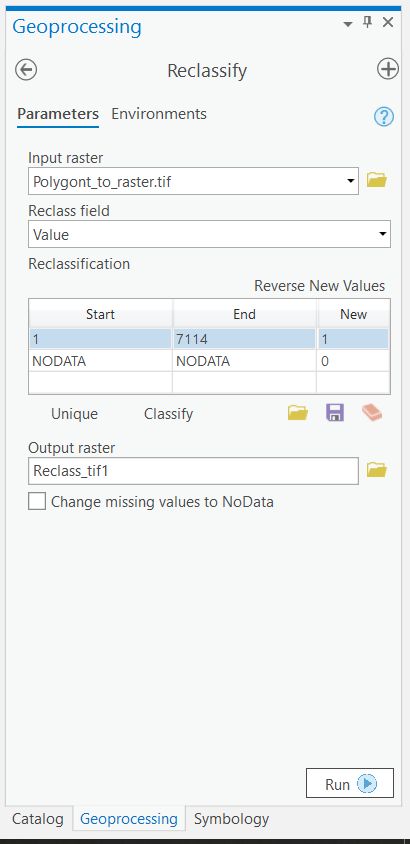
<center>Reclassify Raster</center>

```python
arcpy.ddd.Reclassify("Slum_ground_truth_2004_PolygonToRaster", "Value", "1 1;NODATA 0", r"C:\sample\sample.gdb\Slum_ground_truth_2004_PolygonToRaster_reclass", "DATA")
```

#### Convert to a Thematic Raster with Pixel Type 8bit unsigned
Export the reclassified raster from the previous step to a '8bit unsigned' raster.
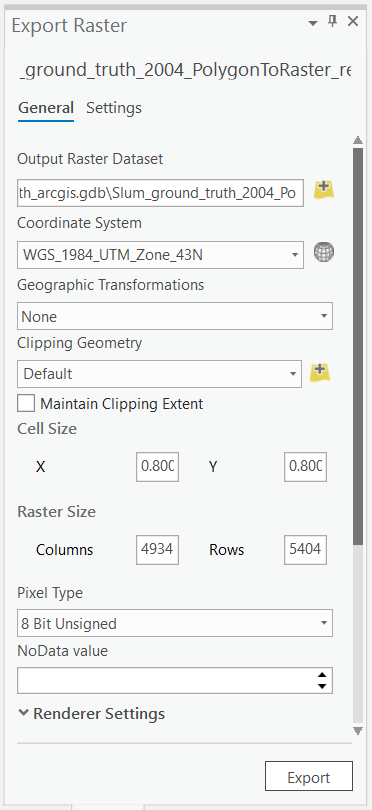
<center>Export Raster</center>


```python
arcpy.management.CopyRaster(r"C:\sample\sample.gdb\Slum_ground_truth_2004_PolygonToRaster_reclass", r"C:\sample\sample.gdb\Slum_ground_truth_2004_PolygonToRaster_reclass_8bitu", '', None, '', "NONE", "NONE", "8_BIT_UNSIGNED", "NONE", "NONE", "GRID", "NONE", "CURRENT_SLICE", "NO_TRANSPOSE")
```

Open 'Catalog Pane' > navigate to the raster you just exported > Right Click and select 'Properties'. In the 'Raster Properties' pane change the source type to 'Themetic'.
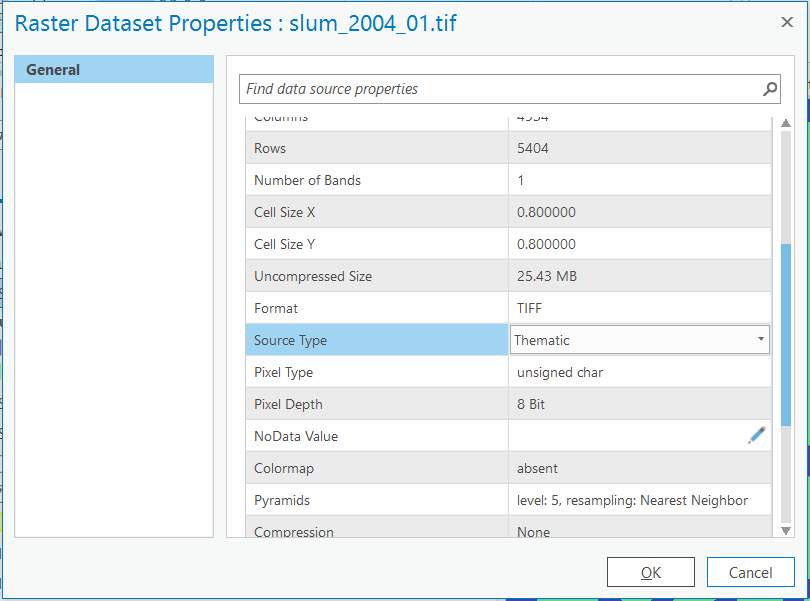
<center>Set the Source Type of Raster to Thematic.</center>


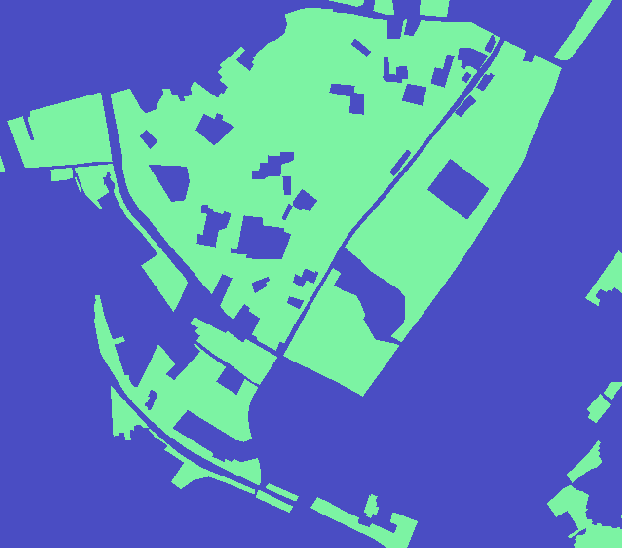
<center>A Subset of our Themetic Raster generated by the previous steps.</center>

### Export training data
Export training data using 'Export Training data for deep learning' tool, [detailed documentation here](#https://pro.arcgis.com/en/pro-app/tool-reference/image-analyst/export-training-data-for-deep-learning.htm)
- Set the **satellite imagery** as 'Input Raster'.
- Set a location where you want to export the training data, it can be an existing folder or the tool will create that for you.
- Set **classified raster** as 'Input Feature Class Or Classified Raster'.
- In the option 'Input Mask Polygons' we can set a mask layer to limit the tool to export training data for only those areas which have slum in it, we can create one by generating a grid on slum boundary layer's extent and dissolving only those polygons which contained slum to a single multipolygon feature.
- 'Tile Size X' & 'Tile Size Y' can be set.
- Select 'Classified Tiles' as the 'Meta Data Format' because we are training an 'Unet Model'.
- In 'Environments' tab set an optimum 'Cell Size' which is small enough to allow model to learn the texture and setting of slum as well as also understand the surrounding context of the slums. For this example we used 0.8 cell size which meant **80cm** on the project coordinate system. 


<div>

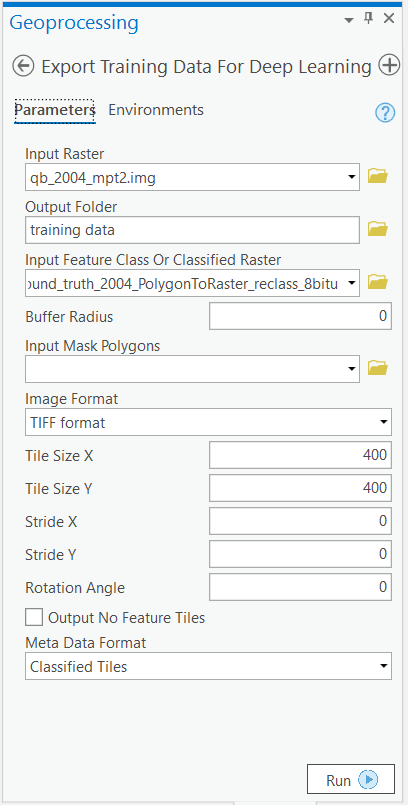
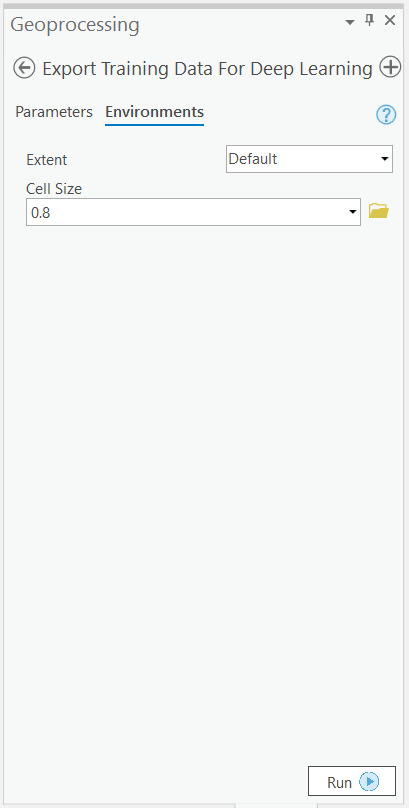
</div>

```python
arcpy.ia.ExportTrainingDataForDeepLearning("Imagery", r"C:\sample\Data\Training Data 400px 30cm", "Building_Footprints_8bitu.tif", "TIFF", 400, 400, 0, 0, "ONLY_TILES_WITH_FEATURES", "Classified_Tiles", 0, None, 0, "grid_200m_Dissolve", 0, "MAP_SPACE", "NO_BLACKEN", "Fixed_Size")
```

This will create all the necessary files needed for the next step in the 'Output Folder', and we will now call it our **training data**.

## Train the Model

As we have already exported our training data, we will now train our model using ArcGIS API for Python. We will be using `arcgis.learn` module which contains tools and deep learning capabilities. Documentation is available <a href="https://developers.arcgis.com/python/guide/install-and-set-up/"> here to install and setup environment</a>.

### Required Imports


In [ ]:
import os
from pathlib import Path

import arcgis
from arcgis.gis import GIS
from arcgis.learn import prepare_data

In [ ]:
gis = GIS('home')

### Prepare Data

The `prepare_data` function takes in the training data and applies various types of transformations and augmentations. We would now use this function and specify the path to our training data and a few parameters to create a fastai databunch. 

`path`: path of folder containing training data.<br/>
`chip_size`: Same as per specified while exporting training data<br/>
`batch_size`: No of images your model will train on each step inside an epoch, it directly depends on the memory of your graphic card. 8 worked for us on a GPU with 11GB memory.

<Item title:"extracting_slums_from_satellite_imagery" type:Image Collection owner:api_data_owner>
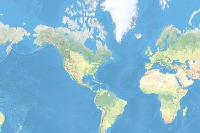

In [3]:
training_data = gis.content.get('8907743562024028af17939b8552eed4')
training_data

In [4]:
filepath = training_data.download(file_name=training_data.name)

In [5]:
import zipfile
with zipfile.ZipFile(filepath, 'r') as zip_ref:
    zip_ref.extractall(Path(filepath).parent)

In [6]:
data_path = Path(os.path.join(os.path.splitext(filepath)[0]))

In [2]:
# Prepare Data
data = prepare_data(data_path,
                    chip_size=400, 
                    batch_size=6)


#### Visualize a few samples from your Training data
To get a sense of what the training data looks like we will use the `show_batch()` method in arcgis.learn which randomly picks a few samples from the training data and visualizes them with the same symbology as in ArcGIS Pro.

`rows`: No of rows we want to see the results for.<br>
`alpha`: controls the opacity of labels(Classified imagery) over the drone imagery

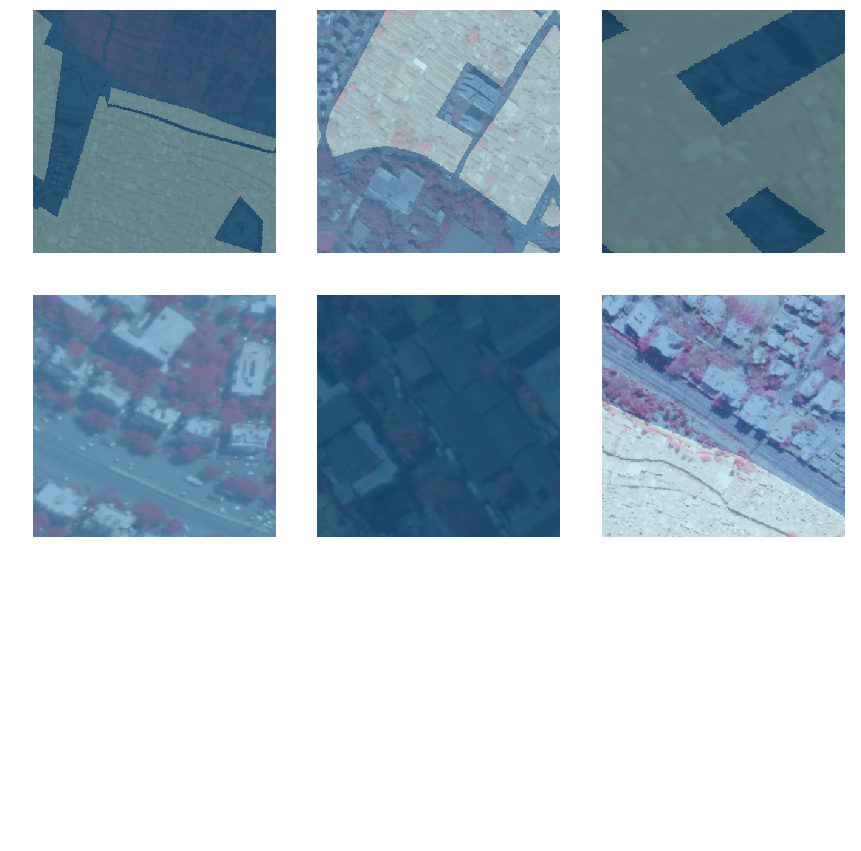

In [14]:
data.show_batch(rows=3, alpha=0.5)

### Load an `UnetClassifier` model

The Code below will create a `UnetClassifier` model, it is based on a state of art deep learning model architecture 'U-net'. This type of model is used where '**pixel wise segmentation**' or in GIS terminology '**imagery classification**' is needed, by default this model will be loaded on a pretrained 'resnet' backbone.  

In [4]:
# Create Unet Model
model = arcgis.learn.models.UnetClassifier(data)

### Find an Optimal Learning Rate

Optimization in deep learning is all about tuning 'hyperparameters', in this step we will find an optimum learning rate for our model on the training data. Learning rate is a very important parameter, while training our model it will see the training data several times and adjust itself (the weights of the network). Too high learning rate will lead to the convergence of our model to an suboptimal solution and too low learning can slow down the convergence of our model. We can use the `lr_find()` method to find an optimum learning rate at which can train a robust model fast enough. 

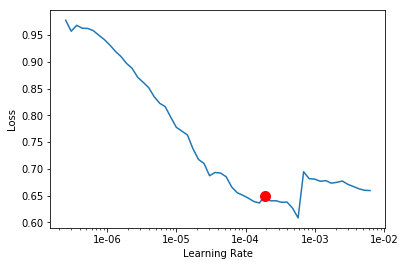

0.00019054607179632462

In [4]:
# Find Learning Rate
model.lr_find()

The above method passes small batches of data to the model at a range of learning rates while records the losses for the respective learning rate after training. The result is this graph where loss has been plotted at y-axis with the respective learning rate at x-axis. Looking at the above graph we can see that the loss continuously decreases after 1e-06 or .000001 and continuous falling until bumping back at 1e-02, we can now pick any value near to the center of this steepest decline. Now we will pick 1e-03 or .001 so that can be set the highest learning rate and lowest learning rate a tenth of it in the next step.

### Fit the model

We will fit our model for 25 epochs. One epoch mean the model will see the complete training set once and so on.

In [ ]:
# Training
model.fit(25, lr=0.0002)


The full training data was split into training set and validation set at the [Prepare Data step](#Prepare-Data), by default the validation set is .2 or 20% of the full training data and the remaining 80% goes in the training set. Here we can see loss on both training and validation set, it helps us to be aware about how well our model generalizes on data which it has never seen and prevent overfitting of the model. As we can see that with only 25 epochs, we are already seeing reasonable results. Further improvement can be achieved through more sophisticated hyperparameter tuning. Let's save the model for further training or inference later. The model should be saved into a model’s folder in your folder. By default, it will be saved into your data path that you specified in the very beginning of this notebook.

### Save the model

We will save the model which we just trained as a '**Deep Learning Package**' or '.dlpk' format. Deep Learning package is the standard format used to deploy deep learning models on the ArcGIS platform. `UnetClassifier` models can be deployed by the tool 'Classify Pixels Using Deep Learning' available in <a href="https://pro.arcgis.com/en/pro-app/tool-reference/image-analyst/classify-pixels-using-deep-learning.htm">ArcGIS Pro</a> as well as <a href="https://developers.arcgis.com/rest/services-reference/classify-pixels-using-deep-learning-.htm">ArcGIS Enterprise</a>. For this sample we will using this model in ArcGIS Pro to extract building footprints.

We will use the `save()` method to save the model and by default it will be saved to a folder '**models**' inside our training data folder itself.

In [ ]:
# Save model to file
model.save('25e')

### Load an Intermediate model to train it further

If we need to further train an already saved model we can load it again using the code below and go back to [Train the model step](#Train-the-Model) and further train it.

In [5]:
# Load Model from previous saved files 
# model.load('25e')


### Preview Results

The code below will pick a few random samples and show us ground truth and respective model predictions side by side. This allows us to preview the results of your model in the notebook itself, once satisfied we can save the model and use it further in our workflow.

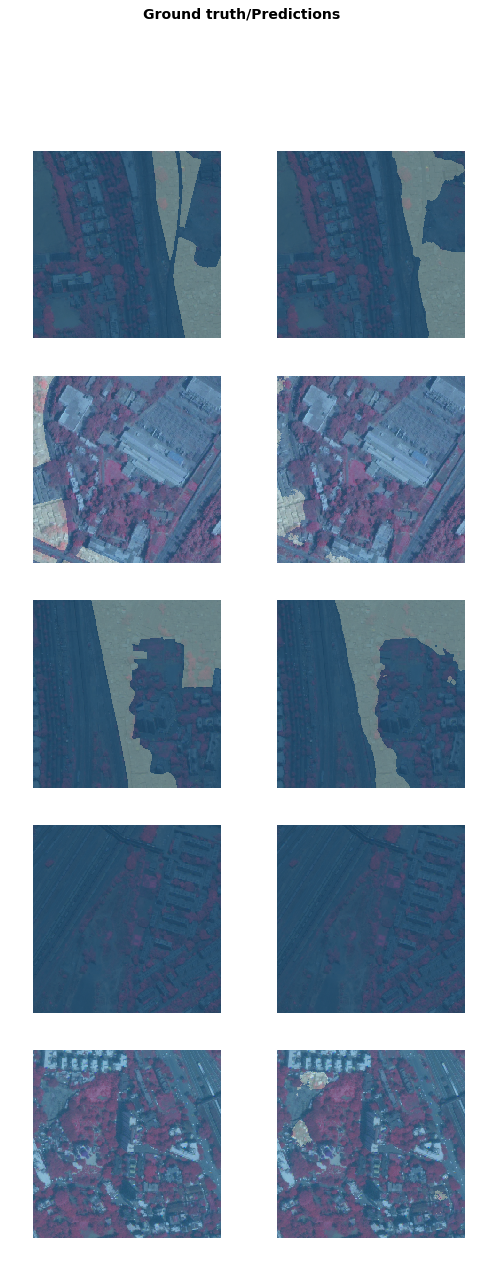

In [6]:
# Preview Results
model.show_results()

## Deploy Model and Extract Slum Boundaries

The deep learning package saved in previous step can be used to extract classified raster using '**Classify Pixels Using Deep Learning**' tool.
Further the classified raster is converted to a vector Polygon layer.


#### Generate a Classified Raster using 'Classify Pixels Using Deep Learning tool'

In this step we will generate a classified raster using 'Classify Pixels Using Deep Learning' tool available in both [**ArcGIS Pro**](https://pro.arcgis.com/en/pro-app/tool-reference/image-analyst/classify-pixels-using-deep-learning.htm) and [**ArcGIS Enterprise**](https://developers.arcgis.com/rest/services-reference/classify-pixels-using-deep-learning-.htm).

- **Input Raster**: The raster layer from which we want to extract building footprints from.
- **Model Definition**: It will be located inside the saved model in 'models' folder in '.emd' format.
- **padding**: The 'Input Raster' is tiled and the deep learning model classifies each individual tile separately before producing the final '**Output Classified Raster**'. This may lead to unwanted artifacts along the edges of each tile as the model has little context to predict accurately. Padding as the name suggests allows us to supply some extra information along the tile edges, this helps the model to predict better. 
- **Cell Size**: Should be close to at which we trained the model, we specified that at the [Export training data step]("#Export-training-data") .
- **Processor Type**: This allows to control whether the system's '**GPU**' or '**CPU**' would be used in to classify pixels, by 'default GPU' will be used if available.
- **Parallel Processing Factor**: This allows us to scale this tool, this tool can be scaled on both 'CPU' and 'GPU'. It specifies that the operation would be spread across how many '**cpu cores**' in case of cpu based operation or '**no of GPU's**' incase of GPU based operation.

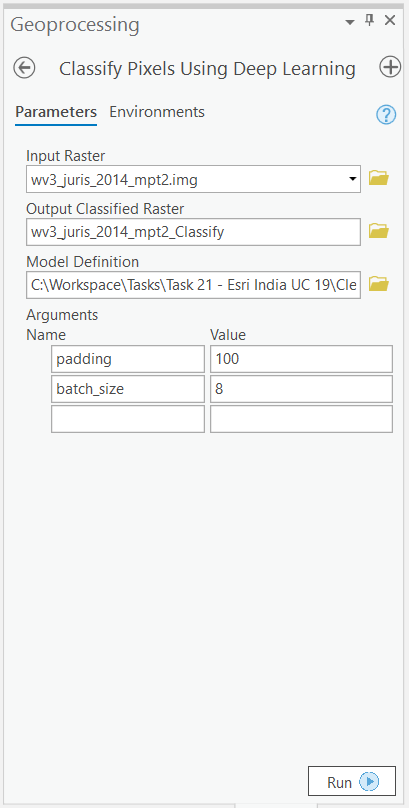
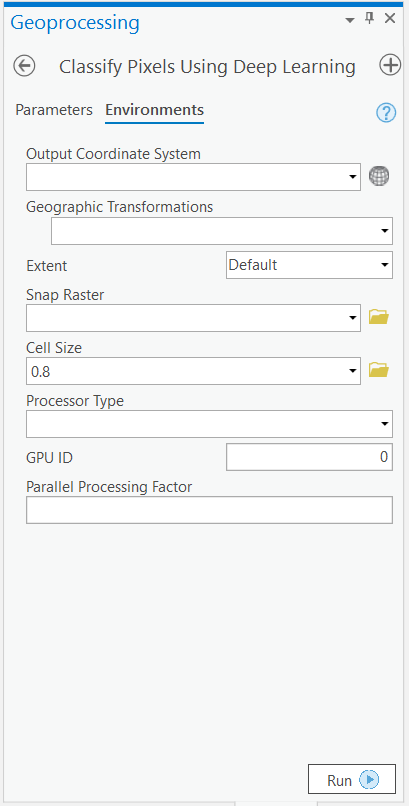

```python
out_classified_raster = arcpy.ia.ClassifyPixelsUsingDeepLearning(r"Imagery\wv3_juris_2014_mpt2.img", r"C:\sample\Training Data\models\140e\140e.emd", "padding 100;batch_size 8"); 
out_classified_raster.save(r"C:\sample\sample.gdb\wv3_juris_2014_mpt2_Classify")
```

Output of this tool will be in form of a 'classified raster' containing both background and slum patches.
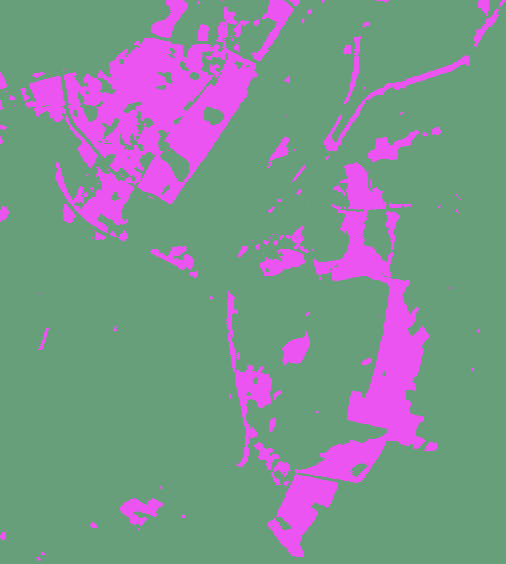
<center>A subset of preditions by our Model</center>

### Postprocessing

#### Majority Filter

We will apply majority filter on the classified raster produced in previous step by our model, this will **Reduce noise** in the classified raster, we would use 'four' neighboring cells majority to smoothen the raster. 
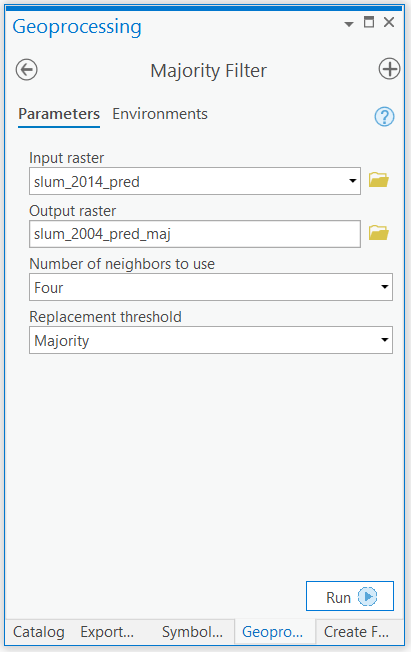

```python
out_raster = arcpy.sa.MajorityFilter("slum_2004_pred", "FOUR", "MAJORITY"); 
out_raster.save(r"C:\sample\sample.gdb\slum_2004_pred_maj")
```

#### Raster to Polygon

We will convert the processed classified raster produced in previous step to a polygon feature class layer using the 'Raster to Polygon' tool. 
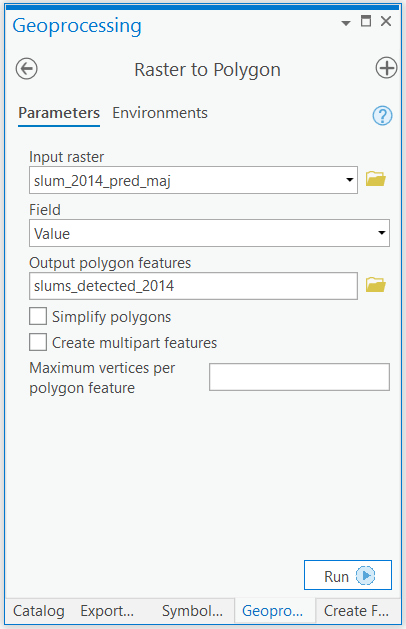

```python
arcpy.conversion.RasterToPolygon("slum_2014_pred_maj", r"C:\sample\sample.gdb\slums_detected_2014", "NO_SIMPLIFY", "Value", "SINGLE_OUTER_PART", None)
```

#### Final Output

The final output will be in form of a feature class. We would first use a tool majority filter to smoothen prediction by our model and then use polygon to raster tool to vectorize our results.

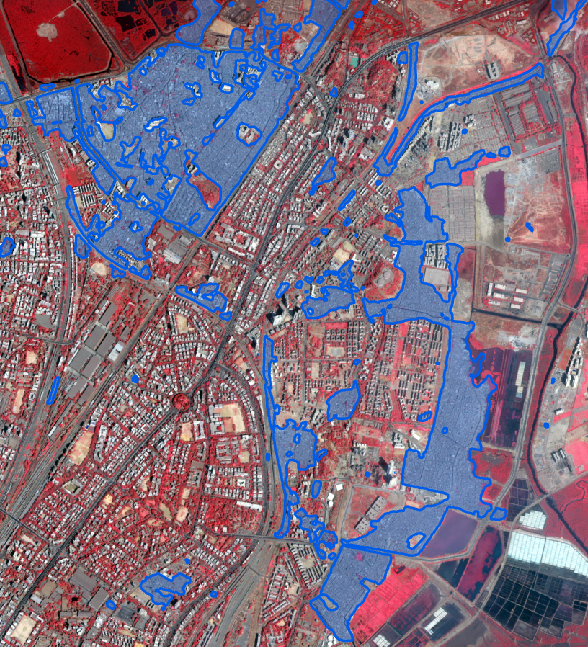

<center> A subset of results overlaid on satellite imagery it was predicted on (Worldview 2014) by our model.</center>

### Conclusion

This type of workflows can be used by government bodies to continuously track and monitor the growth of slum areas, this will help decision makers take informed decisions. Slums are a wide subject and the definition may vary across geographical areas, thus the workflow has to be adapted for better results.

#### An example of ArcGIS dashboard tracking slums

<Item title:"Slum Tracker" type:Dashboard owner:api_data_owner>
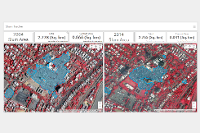

In [12]:
gis = GIS('home')
gis.content.get('809e82a098264c38bfd608e7cc08d5f3')